# Data preprocessing attempt
This code is to try to prepare a qualified format of output for Cesium liabray, to extract features from time series.

The data used is no.17273, date:13-11-2017; Channel:TP-AmnP (TP-AP 273), FHR(Heart Rate A); Downsample: 1000(0.5s/ponit);

## export the raw data
> First the raw data is export from software LabChart into .txt file with:
> * necessary labels (comments from the software)
> * Channel:TP-AmnP (TP-AP 273), FHR (Heart Rate A)
> * Output NaN for values, Time (always seconds), Date, Ignore regional options
> * Downsample: 500 (0.5s/ponit)

> Then convert the .txt file into .csv file with software Excel

## transform into pd.dataframe
> After that, load the data and add column names:
> * load all libraries
> * specify the path to the data
> * add column names and transform the raw data into correct dtype

In [1]:
#load libraries
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

#specify the data dir
data_file = '/Users/leeo/Downloads/17273_13-11-17.csv'

In [2]:
#load the data
data = pd.DataFrame(pd.read_csv(data_file, header=0))
data.columns = ["Time","Date","HR","Resp","Comments"]
data['Time'] = pd.to_timedelta(data['Time'], "s")
data['Date'] = pd.to_datetime(data['Date'])
print("Please check the values for each column! If anything wrong, please recheck the channels!")
data.head()

/anaconda3/envs/p3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Please check the values for each column! If anything wrong, please recheck the channels!


,Time,Date,HR,Resp,Comments
0,10:21:49.355800,2017-11-13,162.6400,2.420671,NaN
1,10:21:49.855800,2017-11-13,167.7724,1.473044,NaN
2,10:21:50.355800,2017-11-13,167.3049,0.916979,NaN
3,10:21:50.855800,2017-11-13,164.9741,2.693337,NaN
4,10:21:51.355800,2017-11-13,170.3801,4.941797,NaN


## transform the data into time series
> * combine the date and time into Date_Time
> * transform the data into time series
> * check the time intervals of data

In [3]:
#combine the date and time
data['Date_Time'] = data['Date']+data['Time']
del data['Date'], data['Time']

#tranform the time into index
data.index = data['Date_Time'] 
del data['Date_Time'] 

# check time intervals
set_time_intervals = pd.Timedelta("0.5s")
actual_time_intervals = data.index[1] -data.index[0]
if (set_time_intervals != actual_time_intervals):
    print("The time intervals now is:", actual_time_intervals, ". Please check the downsample parameter!!")
    
data.head()

,HR,Resp,Comments
Date_Time,,,
2017-11-13 10:21:49.355800,162.6400,2.420671,NaN
2017-11-13 10:21:49.855800,167.7724,1.473044,NaN
2017-11-13 10:21:50.355800,167.3049,0.916979,NaN
2017-11-13 10:21:50.855800,164.9741,2.693337,NaN
2017-11-13 10:21:51.355800,170.3801,4.941797,NaN


## check and handle missing values
> * chech the sparsity of the data
> * compute missing values with carry-forward method
> * check the computation situation

In [4]:
#Check the number of missing values
missing_total=data.isnull().sum().sum()
missing_HR=data["HR"].isnull().sum()
missing_Resp=data["Resp"].isnull().sum()
print("There are {} missings in total, and {} for HR, {} for Resp.".format(missing_total, missing_HR, missing_Resp))
if missing_HR > 10:
    raise Exception('Missing values of HR should not exceed 10.')
if missing_Resp > 10:
    raise Exception('Missing values of Resp should not exceed 10.')

There are 159109 missings in total, and 2 for HR, 0 for Resp.


In [5]:
pd.options.mode.chained_assignment = None
#compute missing values with carry forward method
missing_HR_index = data["HR"][data["HR"].isnull()].index
missing_HR_compute_index = missing_HR_index - set_time_intervals
data["HR"][data["HR"].isnull()] = np.array(data["HR"][missing_HR_compute_index])

missing_Resp_index = data["Resp"][data["Resp"].isnull()].index
missing_Resp_compute_index = missing_Resp_index - set_time_intervals
data["Resp"][data["Resp"].isnull()] = np.array(data["Resp"][missing_Resp_compute_index])

#check the computation situation
missing_total=data.isnull().sum().sum()
missing_HR=data["HR"].isnull().sum()
missing_Resp=data["Resp"].isnull().sum()
print("There are {} missings in total, and {} for HR, {} for Resp.".format(missing_total, missing_HR, missing_Resp))
if missing_HR != 0:
    raise Exception('Something wrong with missing values computing of HR.')
if missing_Resp != 0:
    raise Exception('Something wrong with missing values computing of Resp.')

There are 159107 missings in total, and 0 for HR, 0 for Resp.


## quick exploration of data

The shape of data is:  (159111, 3)


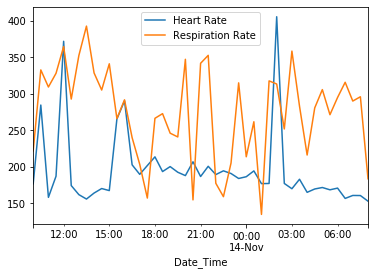

In [6]:
#quick look at the data
print("The shape of data is: ", data.shape)
data["HR"].resample("30T").mean().plot()
(data["Resp"]*100).resample("30T").mean().plot()
plt.legend(["Heart Rate", "Respiration Rate"],
          loc="upper center")

In [ ]:
#Export the data
import csv
export_csv = data.to_csv (data_file[:-4]+"_ts"+data_file[-4:], header=True)

## Transform into cesium format

In [7]:
#tranform the datetimeindex into array
time_array = np.array(data.index.to_pydatetime(), dtype=np.datetime64)
#transform into a list of list of ndarrary

cesium_times = [np.array([time_array.astype("float"),time_array.astype("float")])]

#check the time format
print(type(cesium_times))#list
print(type(cesium_times[0])) #(2, 159112) np.array
print(type(cesium_times[0][0]))
print(type(cesium_times[0][0][0]))
print(cesium_times[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
(2, 159111)


In [8]:
#tranform the measurement values into cesium format
cesium_values =[np.array([data["HR"].to_numpy(),data["Resp"].to_numpy()])]
print(type(cesium_values[0]))

print(type(cesium_values))#list
print(type(cesium_values[0])) #array
print(type(cesium_values[0][0]))
print(type(cesium_values[0][0][0]))
print(cesium_values[0].shape)

<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
(2, 159111)


In [10]:
from cesium import featurize
#set the feature wants to extract
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

fset_cesium = featurize.featurize_time_series(times = cesium_times,
                                              values = cesium_values,
                                              features_to_use=features_to_use)
print(fset_cesium.head())

feature   amplitude            percent_beyond_1_std             maximum  \
channel           0          1                    0         1         0   
0        7680.97217  21.236365              0.00291  0.261541  15371.98   

feature           max_slope              median            ...  \
channel         1         0         1         0         1  ...   
0        17.52629  0.026259  0.000054  177.5802  2.831188  ...   

feature percent_close_to_median             minimum                 skew  \
channel                       0         1         0         1          0   
0                      0.997593  0.983955  10.03566 -24.94644  24.569635   

feature                   std           weighted_average            
channel         1           0         1                0         1  
0       -0.119295  355.818913  1.560819       196.083506  2.765618  

[1 rows x 22 columns]
